### Clustering Assignment Solution
Word Embedding used = Word2Vec

Clustering method = K-means

Clusters best visualized in PCA,T-SNE


In [1]:
#importing dependencies
from __future__ import absolute_import, division, print_function

In [2]:
#for word encoding
import codecs
#finds all path names which match a pattern
import glob
import logging
#concurrency
import multiprocessing
import os
#pretty print, human readable
import pprint
#regular expressions
import re

In [3]:
#natural language toolkit
import nltk
#word 2 vec
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#for visualization
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vinayadithya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vinayadithya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
data = sorted(glob.glob("clustering_assignment.txt"))

In [7]:
data

['clustering_assignment.txt']

In [8]:
#Creating a corpus
corpus_raw = u""
for i in data:
    with codecs.open(i, "r", "utf-8") as file:
        corpus_raw += file.read()
    print("Data in corpus =  {0} ".format(len(corpus_raw)))

Data in corpus =  13886 


In [9]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [10]:
#tokenize data into sentences
raw_sentences = tokenizer.tokenize(corpus_raw)

In [11]:
#converting into list of words
#removing unecessary characters, splitting into words and no punctuations
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [12]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [13]:
#samlpe
print(raw_sentences[78])
print(sentence_to_wordlist(raw_sentences[78]))

Need review of my previous payments
What is the status of my pending payments?
['Need', 'review', 'of', 'my', 'previous', 'payments', 'What', 'is', 'the', 'status', 'of', 'my', 'pending', 'payments']


In [14]:
#counting tokens
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 2,635 tokens


### Training the Word2Vec model

In [15]:
model = w2v.Word2Vec(
    workers=multiprocessing.cpu_count(),
    size=3,
    min_count=3,
    window=5,
    seed =1
)

In [16]:
model.build_vocab(sentences)

In [17]:
print("Word2Vec vocabulary length:", len(model.wv.vocab))

Word2Vec vocabulary length: 173


In [18]:
#training the  model on sentneces
model.train(sentences,total_examples=model.corpus_count,epochs=10)


(9978, 26350)

In [19]:
#creating a directory and saving the new word2vec model
if not os.path.exists("trained"):
    os.makedirs("trained")

In [20]:
model.save(os.path.join("trained", "cluster.w2v"))

In [21]:
#explore the trained model
model = w2v.Word2Vec.load(os.path.join("trained", "cluster.w2v"))

In [22]:
print(len(model.wv.vocab.keys()))

173


In [23]:
data = model.wv.vocab.keys()

In [24]:
import numpy as np
X = np.array([model[w] for w in model.wv.vocab if w in data])
X

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([[ 8.57999027e-01,  1.89254665e+00, -3.86222750e-02],
       [ 7.03122020e-01,  1.36333096e+00, -1.61035992e-02],
       [ 1.40201414e+00,  3.11963773e+00,  3.30135554e-01],
       [ 2.53008962e-01,  1.00107896e+00, -9.92387906e-02],
       [ 9.62975204e-01,  2.05498314e+00,  6.36876002e-02],
       [ 4.96118903e-01,  9.20087337e-01,  1.58896577e-02],
       [ 2.76755840e-01,  1.16818321e+00,  8.11356828e-02],
       [ 5.52879155e-01,  1.12440324e+00,  2.80236956e-02],
       [ 5.53045034e-01,  1.69882631e+00, -3.13570164e-02],
       [ 5.26058137e-01,  1.46050251e+00,  2.59882301e-01],
       [ 2.98177034e-01,  8.64232957e-01,  1.73485905e-01],
       [ 6.25529289e-01,  1.29989207e+00, -1.51001839e-02],
       [ 1.91312984e-01,  8.07878315e-01, -3.67139615e-02],
       [ 1.06950986e+00,  2.63615155e+00,  3.19340795e-01],
       [ 4.46509540e-01,  1.12810075e+00,  4.37972248e-02],
       [ 1.03268743e+00,  2.07830548e+00,  2.98291564e-01],
       [ 3.57527226e-01,  1.18729019e+00

Using k-means clustering algorithm with an Elbow method to select number of clusters

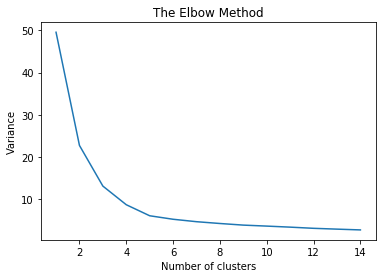

In [25]:
from sklearn.cluster import KMeans
variance = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X)
    variance.append(kmeans.inertia_)
plt.plot(range(1,15),variance)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Variance')
plt.savefig('w2v_elbow.png')
plt.show()

An Elbow has clearly been genrated in the Word2Vec model, since it is more capable of distinguishing between noise and critical data.

The Elbow is always dynamically generated between 4 and 5 clusters, based on the tuning of the hyperparameters 

In [26]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 5)
km.fit(X)
y_kmeans = km.predict(X)

### Reducing dimentions and visualizing using PCA 

In [27]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
#fit_transform fits the data and reduces the dimensionality too. 
principalComponents = pca.fit_transform(X)

In [28]:
principalComponents.shape

(173, 2)

<IPython.core.display.Javascript object>


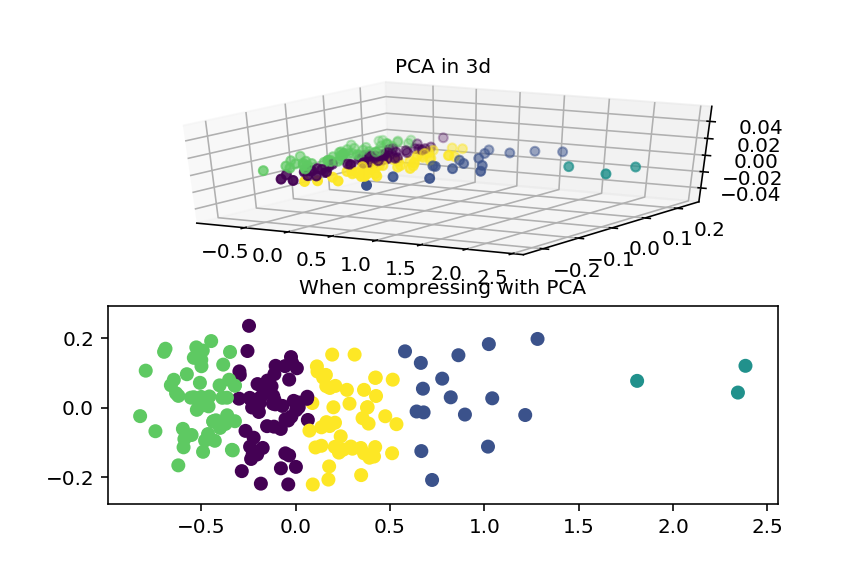

In [45]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
#plt.grid(True)
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1,projection='3d')
ax.set_title('PCA in 3d', fontsize=10)
#ax.scatter(X3[:,0],X3[:,1],X3[:,2],c = y_kmeans)
ax.scatter(principalComponents[:,0],principalComponents[:,1],c = y_kmeans)
ax = fig.add_subplot(2, 1, 2) 
ax.set_title('When compressing with PCA', fontsize=10)
ax.scatter(principalComponents[:,0],principalComponents[:,1],c = y_kmeans)
plt.show()

### Plot using Locally Linear Embedding technique

In [30]:
from sklearn import manifold
lle_data = manifold.LocallyLinearEmbedding(n_neighbors=10, n_components=2).fit_transform(X)

In [31]:
lle_data.shape

(173, 2)

<IPython.core.display.Javascript object>


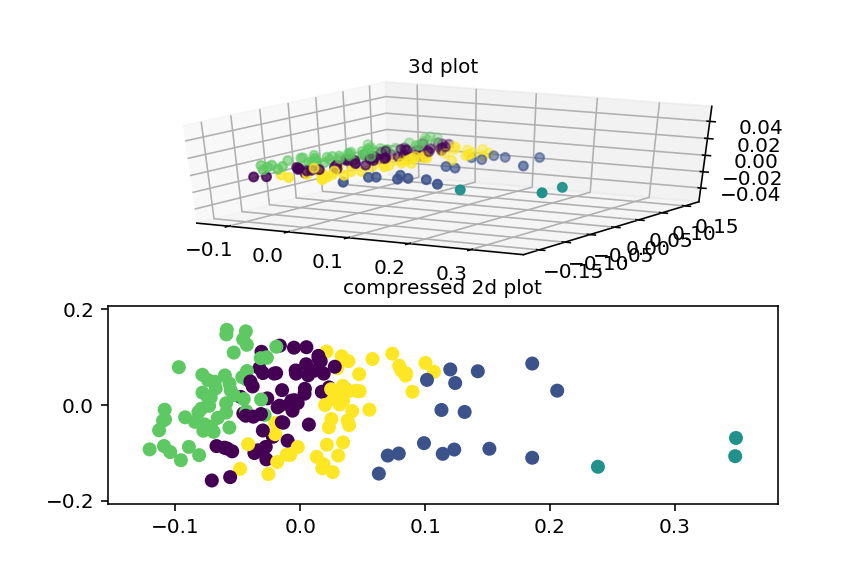

In [46]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1,projection='3d')
ax.set_title('3d plot', fontsize=10)
ax.scatter(lle_data[:,0],lle_data[:,1],c = y_kmeans)
ax = fig.add_subplot(2, 1, 2) 
ax.set_title('compressed 2d plot', fontsize=10)
ax.scatter(lle_data[:,0],lle_data[:,1],c = y_kmeans)
plt.show()

### Plot using T-SNE

In [33]:
tsne_data = manifold.TSNE(n_components=2).fit_transform(X)

/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/base.py:316: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


In [34]:
tsne_data.shape

(173, 2)

<IPython.core.display.Javascript object>


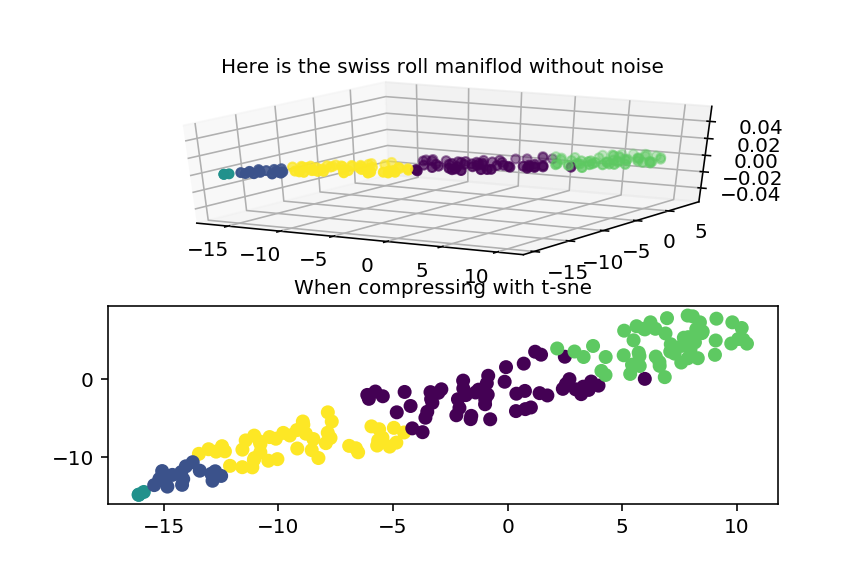

In [47]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1,projection='3d')
ax.set_title('Here is the swiss roll maniflod without noise', fontsize=10)
ax.scatter(tsne_data[:,0],tsne_data[:,1],c = y_kmeans)
ax = fig.add_subplot(2, 1, 2) 
ax.set_title('When compressing with t-sne', fontsize=10)
ax.scatter(tsne_data[:,0],tsne_data[:,1],c = y_kmeans)


### Plot using ISOmap

In [36]:
iso = manifold.Isomap(n_neighbors=6, n_components=2)
iso.fit(X)
manifold_data = iso.transform(X)

In [37]:
manifold_data.shape

(173, 2)

<IPython.core.display.Javascript object>


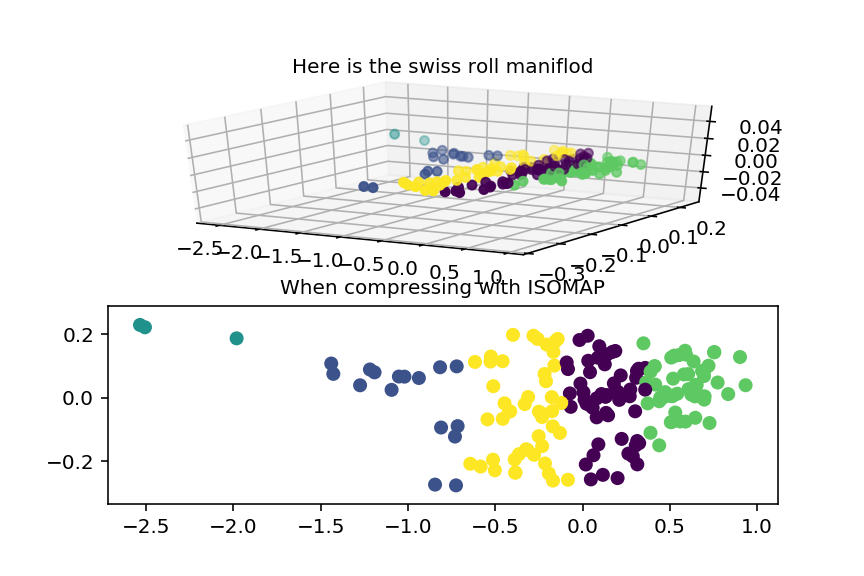

In [38]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1,projection='3d')
ax.set_title('Here is the swiss roll maniflod', fontsize=10)
ax.scatter(manifold_data[:,0],manifold_data[:,1],c = y_kmeans)
ax = fig.add_subplot(2, 1, 2) 
ax.set_title('When compressing with ISOMAP', fontsize=10)
ax.scatter(manifold_data[:,0],manifold_data[:,1],c = y_kmeans)
plt.show()

The sense of accuracy of the model is gathered from the below cells where we try to find out what the model has leant and how it has mapped similar words together. It is to be kept in mind that the original data fed to the model includes a significant amount of noise

In [39]:
model.most_similar("money")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('personal', 0.9999638795852661),
 ('pay', 0.9994802474975586),
 ('frm', 0.9994213581085205),
 ('is', 0.9993774890899658),
 ('business', 0.9993257522583008),
 ('Please', 0.99919593334198),
 ('given', 0.999121367931366),
 ('your', 0.9991093873977661),
 ('fees', 0.9990379214286804),
 ('Get', 0.9989632368087769)]

In [40]:
model.most_similar("account")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('of', 0.9999390244483948),
 ('Have', 0.9999316334724426),
 ('financial', 0.9998831748962402),
 ('service', 0.9996821284294128),
 ('much', 0.9996273517608643),
 ('me', 0.9995616674423218),
 ('bill', 0.9995324015617371),
 ('Rs', 0.9995054006576538),
 ('expenses', 0.9994540810585022),
 ('in', 0.9991583228111267)]

In [41]:
model.most_similar("transfer")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('EMI', 0.9999197721481323),
 ('clear', 0.9998575448989868),
 ('savings', 0.999843418598175),
 ('in', 0.9996379017829895),
 ('funds', 0.9994837045669556),
 ('a', 0.9992120265960693),
 ('get', 0.9992022514343262),
 ('friend', 0.9991366267204285),
 ('finances', 0.9989339113235474),
 ('what', 0.9989338517189026)]

In [42]:
model.most_similar("credit")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('at', 0.9999438524246216),
 ('payment', 0.9999278783798218),
 ('do', 0.9998903274536133),
 ('Send', 0.9998608231544495),
 ('friend', 0.9998171925544739),
 ('available', 0.9997994303703308),
 ('opening', 0.9996772408485413),
 ('my', 0.9996771216392517),
 ('another', 0.999660849571228),
 ('Need', 0.999591588973999)]

In [43]:
model.most_similar("investment")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('asap', 0.9990987181663513),
 ('cheque', 0.9962367415428162),
 ('Could', 0.9958004951477051),
 ('Financial', 0.9950643181800842),
 ('we', 0.9937152862548828),
 ('mobile', 0.9935123324394226),
 ('property', 0.9932364225387573),
 ('Want', 0.9918184876441956),
 ('can', 0.9906172752380371),
 ('know', 0.9899706840515137)]

In [44]:
model.most_similar("balance")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('get', 0.9999390244483948),
 ('finances', 0.9999176263809204),
 ('transaction', 0.9996744990348816),
 ('an', 0.9996469616889954),
 ('want', 0.9996346235275269),
 ('with', 0.9996258020401001),
 ('a', 0.9995980262756348),
 ('house', 0.9994649887084961),
 ('would', 0.9993715286254883),
 ('savings', 0.9991909861564636)]

## Inference:

The elbow curve tells us that the optimal number of clusters are 4,5.
Plotting these cluster values shows us a clear distiction in the intents.
Visualization from the Word2Vec model shows us how the model is more capable of differtiatig between noisy data points.

The word2vec model combined with the TF-IDF word embedding model, provides a clear conclusion to the number of intents and clusters we have in our data. It solidifies our understnading of the clusters(5) and their names which are

1. Loan requirement questions
2. Asking the bot to clear bills
3. Outstanding balance check questions
4. Money Transfer queries
5. FAQs

